In [ ]:
import os#
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#
import pandas as pd
import torch
import numpy as np
import importlib
from stk_search.utils import database_utils

os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [ ]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
df_total_path_bench = 'data/output/Full_dataset/df_train_pred_learned_better_format.csv'
df_precursor_path ="data/output/Prescursor_data/precursor_data_200324.pkl"
df_precursor_Mordred_path="data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl"

search_space_loc = "data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl"#"data/input/EXP_search_space/6_frag_all_2024_05_11_22_40_37//search_space_0.pkl"

In [ ]:
# load and check the search space
from stk_search import Search_space
search_space = pd.read_pickle(search_space_loc)
print(' Search space condition list:', search_space.conditions_list)
print('shape of df_precursors:', search_space.df_precursors.shape)
print('search space syntax:', search_space.syntax)


 Search space condition list: [[], [], [], [], [], []]
shape of df_precursors: (274, 49)
search space syntax: [0, 1, 2, 3, 4, 5]


In [ ]:
# load and check the dataframe to search over and the df_precursors
df_Benchmark = pd.read_csv(df_total_path_bench)
df_precursor_Mordred = pd.read_pickle(df_precursor_Mordred_path)
df_precursors = pd.read_pickle(df_precursor_path)
print('shape of df_Benchmark:', df_Benchmark.shape)
print('shape of df_precursors:', df_precursors.shape)
print('shape of df_precursor_Mordred:', df_precursor_Mordred.shape)
print(df_Benchmark[df_Benchmark['target']>0].shape[0]/df_Benchmark.shape[0])

shape of df_Benchmark: (89856, 9)
shape of df_precursors: (306, 40)
shape of df_precursor_Mordred: (312, 101)
0.0001558048433048433


In [ ]:
num_of_elem_in_SP = search_space.check_df_for_element_from_sp(df_Benchmark).shape
print('number of elements in the benchmark in the search space:', num_of_elem_in_SP)

number of elements in the benchmark in the search space: (46892, 9)


In [ ]:
# set the benchmark parameters  
exp_name = "Benchmark_56K_dataset"
num_elem_initialisation=5
num_iteration=500
target = 'target'
aim = 'maximise'
case_name_list = ["ea_surrogate_new", "BO_learned_new"] # ['evolution_algorithm','random','BO_precursor']#,["ea_surrogate_new", "BO_learned_new"] # "ea_surrogate", "BO_learned"
config_dir_list = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322/SchNet/splitrand-nummol50000"]
config_dir_list_new = [f"/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516/SchNet/splitrand-nummol{num_mol}" for num_mol in [10000]]

In [ ]:
#importlib.reload(MultifidelityBayesianOptimisation)

def run_search_on_hpc(
    case_name="ea_surrogate",
    df_path_total=df_total_path_bench,
    df_precursors_path=df_precursor_path,
    frag_properties="selected",
    config_dir="",
    dataset_representation_path = None,
    test=False,
    lim_counter = 5,
    which_acquisition = "EI",
    budget =100,

):
    string_to_run_notebook, script_qsub = run_hpc_utils.generate_string_run(
        case=case_name,
        target=target,
        aim=aim,
        num_elem_initialisation=num_elem_initialisation,
        num_iteration=num_iteration,
        df_path=df_path_total,
        benchmark=True,
        test_name=exp_name,
        df_precursors_path=df_precursors_path,
        frag_properties=frag_properties,
        config_dir=config_dir,
        dataset_representation_path=dataset_representation_path,
        lim_counter = lim_counter,
        which_acquisition = which_acquisition,
        search_space_loc = search_space_loc,
        budget = budget
    )
    if test:
        %run {string_to_run_notebook}
        return string_to_run_notebook
    run_hpc_utils.submit_job(script_qsub, case_name)




In [13]:
#importlib.reload(Look_up_table)

run_search_on_hpc(
                case_name='MFBO',
                df_precursors_path=df_precursor_path,
                which_acquisition = "KG",
                test=False,
                budget =100,   
            )

src/dev_scripts/run_search_new.py  --case MFBO --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 5 --which_acquisition KG --dataset_representation_path None --df_path data/output/Full_dataset/df_train_pred_learned_better_format.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --search_space_loc data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl --frag_properties selected --lim_counter 5 --budget 100
9498615[].pbs


In [8]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"data/output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        list_json.append(json.load(f))
    f.close()
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
df = df[df['benchmark']]
print(df.shape)
df_all = df.copy()
df_all.head()


(2716, 22)


,num_iteration,num_elem_initialisation,test_name,case,target_name,config_dir,aim,which_acquisition,lim_counter,search_space_loc,...,df_precursors_path,benchmark,dataset_representation_path,frag_properties,run_search_name,search_output_folder,date,git_version,budget,search_exp_file
1,500,50,Benchmark_56K_dataset,BO_precursor,target,,maximise,EI,5,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/precursor_data_200...,True,None,selected,a7ebd9293ec84c7c8e118bfb8b1c234e,data/output/search_experiment/6_frag/Benchmark...,20240516,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/Benchmark...
2,300,50,new_target,ea_surrogate,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/calculation_data_p...,True,/rds/general/ephemeral/user/ma11115/ephemeral/...,all,ac97e57ea5cf4449a242bc02251a0e62,data/output/search_experiment/6_frag/new_target,20240323,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/new_targe...
3,300,50,frag_prop,BO_precursor,target,/rds/general/user/ma11115/home/STK_Search/STK_...,0.0,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,True,/rds/general/user/ma11115/home/STK_Search/STK_...,all,ddb27e04633545739bbfadba54b279e3,data/output/search_experiment/6_frag/frag_prop,20240308,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/frag_prop...
4,500,50,Benchmark_75K_dataset,ea_surrogate_new,target,/rds/general/user/ma11115/home/STK_Search/STK_...,maximise,EI,5,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/precursor_data_200...,True,None,selected,29aa2aea54e243ac9ca7f0a302160199,data/output/search_experiment/6_frag/Benchmark...,20240512,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/Benchmark...
5,300,50,different_representations_dataset,ea_surrogate,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/calculation_data_p...,True,/rds/general/ephemeral/user/ma11115/ephemeral/...,all,cf384899f2ed49d298302d960a2352c7,data/output/search_experiment/6_frag/different...,20240322,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/different...


In [9]:
num_iteration = 500
num_elem_initialisation = 50
oligomer_size = 6 
search_space_loc = '/rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl'
#df_filtered = df_all[df_all['num_iteration']==num_iteration]
#df_filtered = df_filtered[df_filtered['num_elem_initialisation']==num_elem_initialisation]
df_filtered = df_all[df_all['df_path']==df_total_path_bench]

df_filtered = df_filtered[df_filtered['oligomer_size']==oligomer_size]
print(df_filtered.shape)

print(df_filtered.shape)
df_list = df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir','df_path','df_precursors_path',])
print(len(df_list))
df_list.describe()

(66, 22)
(66, 22)
3


num_iteration  \
                                                                                                                                                                                                        count   
case frag_properties which_acquisition config_dir                                         df_path                                            df_precursors_path                                                 
MFBO selected        EI                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...           7.0   
                                       /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...           4.0   
                     KG                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...          55.0   

                                                                                                                                                                                                        \
                                                                                                                                                                                                  mean   
case frag_properties which_acquisition config_dir                                         df_path                                            df_precursors_path                                          
MFBO selected        EI                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  500.0   
                                       /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  500.0   
                     KG                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  500.0   

                                                                                                                                                                                                      \
                                                                                                                                                                                                 std   
case frag_properties which_acquisition config_dir                                         df_path                                            df_precursors_path                                        
MFBO selected        EI                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  0.0   
                                       /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  0.0   
                     KG                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  0.0   

                                                                                                                                                                                                        \
                                                                                                                                                                                                   min   
case frag_properties which_acquisition config_dir                                         df_path                      

In [10]:
import pandas as pd
def join_name(x):
    return '*'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 5
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_path'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case'] = df_summary_1['key'].apply(lambda x: x.split('*')[0])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])

df_summary_1['which_acquisition'] = df_summary_1['key'].apply(lambda x: x.split('*')[2])
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case,num_mol_training,which_acquisition
0,MFBO*selected*EI**data/output/Full_dataset/df_...,2,data/output/Full_dataset/df_train_pred_learned...,MFBO*selected*EI**data/output/Full_dataset/df_...,MFBO,MFBO*selected*EI**data/output/Full_dataset/df_...,EI
1,MFBO*selected*EI*/rds/general/user/ma11115/hom...,1,data/output/Full_dataset/df_train_pred_learned...,MFBO*selected*EI*/rds/general/user/ma11115/hom...,MFBO,10000*data/output/Full_dataset/df_train_pred_l...,EI
2,MFBO*selected*KG**data/output/Full_dataset/df_...,51,data/output/Full_dataset/df_train_pred_learned...,MFBO*selected*KG**data/output/Full_dataset/df_...,MFBO,MFBO*selected*KG**data/output/Full_dataset/df_...,KG


In [11]:
for keys in df_summary_1['key']:
    print(keys)
    print(len(results_dict[keys]))
    res = results_dict[keys]
    for results in res:
        print(len(results['fitness_acquired']))

MFBO*selected*EI**data/output/Full_dataset/df_train_pred_learned_better_format.csv*data/output/Prescursor_data/precursor_data_200324.pkl
2
197
198
MFBO*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516/SchNet/splitrand-nummol10000*data/output/Full_dataset/df_train_pred_learned_better_format.csv*data/output/Prescursor_data/precursor_data_200324.pkl
1
126
MFBO*selected*KG**data/output/Full_dataset/df_train_pred_learned_better_format.csv*data/output/Prescursor_data/precursor_data_200324.pkl
51
40
39
37
39
40
38
38
40
39
32
39
7
39
40
42
42
40
40
38
43
37
40
40
39
38
38
39
38
38
42
38
43
39
40
38
34
39
24
38
41
33
38
37
38
38
38
41
38
33
29
40


In [ ]:
res[6]['searched_space_df']

,InChIKey_0,InChIKey_1,InChIKey_2,InChIKey_3,InChIKey_4,InChIKey_5,fidelity
0,DOXWISNBDAHQBD-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,1.0
1,LXPGOLVTQAXCFY-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,MRBCQJMEGDDUNN-WMZJFQQLSA-N,MTLFYGNDDYBIIU-JYOAFUTRSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,1.0
2,NACLVJFIPGLGGF-UHFFFAOYSA-N,QKOAHMWMROSOCB-UHFFFAOYSA-N,XJDUSLLTQXVMPI-UHFFFAOYSA-N,SNMJIXVGAOBXCS-UHFFFAOYSA-N,WLJMWJRNANCLLB-UQCOIBPSSA-N,XJDUSLLTQXVMPI-UHFFFAOYSA-N,1.0
3,KYORXLIHDAZXPK-UHFFFAOYSA-N,MRBCQJMEGDDUNN-WMZJFQQLSA-N,XORWEKRDQCXPID-UHFFFAOYSA-N,XZXYPNZEWNZGOF-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,MSUPZGGVRIRXAI-UHFFFAOYSA-N,1.0
4,HNRHIGPDSSXEJA-FARCUNLSSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,AWRKSCQREBTNFL-UHFFFAOYSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,0.5
5,KYORXLIHDAZXPK-UHFFFAOYSA-N,WKBJSXQNMQQYDA-UHFFFAOYSA-N,XORWEKRDQCXPID-UHFFFAOYSA-N,XZXYPNZEWNZGOF-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,MSUPZGGVRIRXAI-UHFFFAOYSA-N,0.5
6,DOXWISNBDAHQBD-UHFFFAOYSA-N,GKKUHQQNQBVLSW-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,0.5
7,DOXWISNBDAHQBD-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,MSUPZGGVRIRXAI-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,1.0
8,WVGHJMFKJADIAM-UHFFFAOYSA-N,GKKUHQQNQBVLSW-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,0.5
9,DOXWISNBDAHQBD-UHFFFAOYSA-N,GKKUHQQNQBVLSW-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,0.5


NameError: name 'res' is not defined

In [ ]:
res[6]['searched_space_df']['target']= res[6]['fitness_acquired']
res[6]['searched_space_df']['ids_acquired']= res[6]['ids_acquired']
res[6]['searched_space_df'][res[6]['searched_space_df']['fidelity']==max(res[6]['searched_space_df']['fidelity'])]

,InChIKey_0,InChIKey_1,InChIKey_2,InChIKey_3,InChIKey_4,InChIKey_5,fidelity,target,ids_acquired
0,DOXWISNBDAHQBD-UHFFFAOYSA-N,HZYBLPHGWLNIQV-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,WVGHJMFKJADIAM-UHFFFAOYSA-N,DOXWISNBDAHQBD-UHFFFAOYSA-N,1.0,-0.910442,0
1,LXPGOLVTQAXCFY-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,MRBCQJMEGDDUNN-WMZJFQQLSA-N,MTLFYGNDDYBIIU-JYOAFUTRSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,1.0,-1.614978,1
2,NACLVJFIPGLGGF-UHFFFAOYSA-N,QKOAHMWMROSOCB-UHFFFAOYSA-N,XJDUSLLTQXVMPI-UHFFFAOYSA-N,SNMJIXVGAOBXCS-UHFFFAOYSA-N,WLJMWJRNANCLLB-UQCOIBPSSA-N,XJDUSLLTQXVMPI-UHFFFAOYSA-N,1.0,-2.863132,2
3,KYORXLIHDAZXPK-UHFFFAOYSA-N,MRBCQJMEGDDUNN-WMZJFQQLSA-N,XORWEKRDQCXPID-UHFFFAOYSA-N,XZXYPNZEWNZGOF-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,MSUPZGGVRIRXAI-UHFFFAOYSA-N,1.0,-1.611536,3
4,HNRHIGPDSSXEJA-FARCUNLSSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,AWRKSCQREBTNFL-UHFFFAOYSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,0.5,-2.909112,4


NameError: name 'res' is not defined

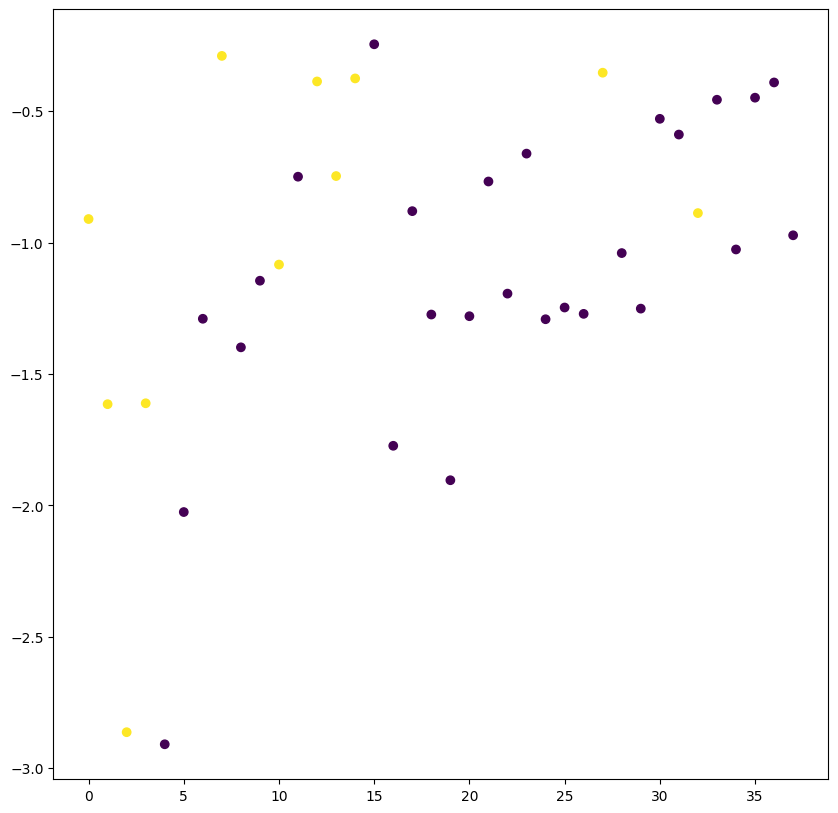

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,10))
res_num= 6
ax.scatter(x=res[res_num]['ids_acquired'],y = res[res_num]['fitness_acquired'],c=res[res_num]['searched_space_df']['fidelity'],cmap='viridis')


In [ ]:

plt.matplotlib.style.use(
    "https://gist.githubusercontent.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea/raw/64a78942d3f7b4b5054902f2cee84213eaff872f/matplotlibrc"
)
cool_colors = [
    "#00BEFF",
    "#D4CA3A",
    "#FF6DAE",
    "#67E1B5",
    "#EBACFA",
    "#9E9E9E",
    "#F1988E",
    "#5DB15A",
    "#E28544",
    "#52B8AA",
]
cool_colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]

plt.rcParams.update({"font.size": 14})

search_to_color = {
    "BO": cool_colors[0],
    "random": cool_colors[1],
    "evolutionary": cool_colors[2],
    "RF": cool_colors[3],
    "RF (div)": cool_colors[5],
}

def plot_simple_regret_MFBO(
    res,
    nb_iterations=100,
    axs=None,
    color=search_to_color["BO"],
    label="BO",
    target_name="target",
    df_total=[],
    nb_initialisation=0,
):
    """
    Plot the maximum value acquired up to this point

    Args:
        res (list): The results of the search
        nb_iterations (int): The number of iterations
        axs (matplotlib.pyplot): The axis to plot
        color (str): The color of the plot
    """
    target_value = np.max(df_total[df_total['fidelity']==max(df_total['fidelity'])][target_name].values)
    nb_iterations_range = np.arange(nb_iterations) + 1
    y_max_mu = -10 * np.ones(nb_iterations)
    y_max_sig_bot = -10 * np.ones(nb_iterations)
    y_max_sig_top = -10 * np.ones(nb_iterations)
    nb_runs = len(res)
    for i in range(1, nb_iterations + 1):
        # max value acquired up to this point
        y_maxes = [
            np.max(
                res[r]["fitness_acquired"][
                    nb_initialisation : nb_initialisation + i
                ]
                - target_value
            )
            for r in range(nb_runs)
        ]
        y_maxes = np.array(y_maxes)
        assert np.size(y_maxes) == nb_runs
        y_max_mu[i - 1] = np.mean(y_maxes)
        y_max_sig_bot[i - 1] = np.std(y_maxes[y_maxes < y_max_mu[i - 1]])
        y_max_sig_top[i - 1] = np.std(y_maxes[y_maxes > y_max_mu[i - 1]])
    axs.plot(nb_iterations_range, y_max_mu, label=label, color=color)
    axs.fill_between(
        nb_iterations_range,
        y_max_mu - y_max_sig_bot,
        y_max_mu + y_max_sig_top,  #
        alpha=0.2,
        ec="None",
        color=color,
    )
    axs.set_xlabel("number of evaluated oligomers")
    axs.set_ylabel("simple regret ")
    axs.set_ylim([df_total[target_name].min(), df_total[target_name].max()])
    return max(y_max_mu)

In [93]:
## test mfbo acquisition function


72

In [95]:
from stk_search.Search_algorithm import MultifidelityBayesianOptimisation
from stk_search.Representation import (
    Representation_from_fragment,
    Representation_3d_from_fragment,
)
MFBO = MultifidelityBayesianOptimisation.MultifidelityBayesianOptimisation(
            budget=100, 
            which_acquisition='KG', 
            fidelity_col = 36,
            lim_counter=5)

frag_properties = []
frag_properties = df_precursors.columns[17:23]


print(frag_properties)
MFBO.Representation = (
    Representation_from_fragment.Representation_from_fragment(
        df_precursors, frag_properties
    )
)
search_algorithm = MFBO

Index(['1 Excited state Energy (eV)', '1 Excited state Osc',
       '2 Excited state Energy (eV)', '2 Excited state Osc',
       '3 Excited state Energy (eV)', '3 Excited state Osc'],
      dtype='object')


In [96]:
from stk_search import Search_Exp
from stk_search.Objective_function import Look_up_table
objective_function = Look_up_table(
            df_Benchmark, oligomer_size, target_name='target', aim=aim
        )

number_of_iterations = num_iteration
verbose = True
num_elem_initialisation = 50
S_exp = Search_Exp.Search_exp(
    search_space_loc,
    search_algorithm,
    objective_function,
    number_of_iterations,
    verbose=verbose,
)

S_exp.num_elem_initialisation = num_elem_initialisation
S_exp.benchmark = True
S_exp.df_total = df_Benchmark
# S_exp.df_precur


In [97]:
S_exp.initialise_search_space()  # the initialisation of the space here makes it too rigid to change it without saving a new search_space
        # get initial elements
ids_acquired, df_search_space = (
    S_exp.search_algorithm.initial_suggestion(
        SP=S_exp.search_space,
        num_elem_initialisation=S_exp.num_elem_initialisation,
        benchmark=S_exp.benchmark,
        df_total=S_exp.df_total,
    )
)
if (S_exp.search_algorithm.budget is not None) and (S_exp.search_algorithm.budget < 0): 
    raise Exception('Budget exhausted by Initial Sample')
        
S_exp.df_search_space = df_search_space
for id in range(S_exp.num_elem_initialisation):
    # evaluate the element
    S_exp.evaluate_element(
        element_id=ids_acquired[id],
        objective_function=S_exp.objective_function,
    )
if S_exp.verbose:
    print(f"max fitness acquired: {max(S_exp.fitness_acquired)}")
    print(f"min fitness acquired: {min(S_exp.fitness_acquired)}")

element Inchikey suggested: CRANHIOWXQXFDX-MTCMGWGTSA-N, Eval: -2.4863324
fitness suggested: 0    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: XHQNKRAEWFLEPB-NLJQFXOZSA-N, Eval: -1.9710966
fitness suggested: 1    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: LGBZNONTOBTTPW-UHFFFAOYSA-N, Eval: -1.6495284
fitness suggested: 2    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: WBOLULYCDVDMIQ-RHQFVSDJSA-N, Eval: -1.9389666
fitness suggested: 3    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: JZVLWTNSPVZGPO-UHFFFAOYSA-N, Eval: -1.757938
fitness suggested: 4    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: IGMXXNIUUJUISV-SPYKILETSA-N, Eval: -2.578246586
fitness suggested: 5    1.0
Name: fidelity, dtype: float64
element Inchikey suggested: CGZWYOKQUTYZFW-UHFFFAOYSA-N, Eval: -1.8960292
fitness suggested: 6    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: UJHOSNZVDXCYLP-UHFFFAOYSA-N, Eval: -1.84

In [98]:
df_search = S_exp.df_search_space.copy()
fitness_acquired = np.array(S_exp.fitness_acquired)
repr = df_search.loc[S_exp.ids_acquired, :]

X_rpr = S_exp.search_algorithm.generate_rep_with_fidelity(repr)
y_explored_BO_norm = torch.tensor(
    S_exp.fitness_acquired, dtype=torch.float64
)
y_explored_BO_norm = (
    y_explored_BO_norm - y_explored_BO_norm.mean(axis=0)
) / (y_explored_BO_norm.std(axis=0))
y_explored_BO_norm = y_explored_BO_norm.reshape(-1, 1)

# train model
S_exp.search_algorithm.train_model(X_rpr, y_explored_BO_norm)

In [99]:
Xrpr.shape

torch.Size([266, 73])

In [100]:
SP=S_exp.search_space
benchmark=S_exp.benchmark
df_total=S_exp.df_total
df_elements = S_exp.search_algorithm.generate_element_to_evaluate(
            fitness_acquired, df_search.iloc[:,:-1], SP, benchmark, df_total
        )

Xrpr = S_exp.search_algorithm.generate_rep_with_fidelity(df_elements)


In [103]:
# class to define the search algorithm
import os
import torch
import numpy as np
import pandas as pd
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood
from stk_search.Search_algorithm.Search_algorithm import Search_Algorithm
from stk_search.Search_space import Search_Space
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition import PosteriorMean
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.utils import project_to_target_fidelity
from botorch import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize

X_unsqueezed = Xrpr.double()
X_unsqueezed = X_unsqueezed.reshape(-1, 1, X_unsqueezed.shape[1])
bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]], dtype=torch.float64)   
target_fidelities = { S_exp.search_algorithm.fidelity_col:1}
cost_model = AffineFidelityCostModel(fidelity_weights=target_fidelities, fixed_cost=1.0)
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(S_exp.search_algorithm.model),
        d=37,
        columns=[36],
        values=[1],
    )                
_, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:,:-1],
        q=1,
        num_restarts= 2,
        raw_samples=4
)

In [104]:
X_unsqueezed.shape

torch.Size([194, 1, 37])

In [129]:
import datetime
time_now = datetime.datetime.now()
number_of_element = 10
acquisition_function = qMultiFidelityKnowledgeGradient(
        model=S_exp.search_algorithm.model,
        num_fantasies= 50,
        cost_aware_utility=cost_aware_utility,
        project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
        current_value=current_value
)
#with torch.no_grad():  # to avoid memory issues; we arent using the gradient...
acquisition_values = acquisition_function.evaluate(
        X_unsqueezed[:number_of_element,:,:] ,
        bounds=bounds
        ).detach()  # runs out of memory
print('time to run acquisition:', datetime.datetime.now()-time_now, 'for ', number_of_element, 'elements')

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/gpytorch.py:99: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


time to run acquisition: 0:00:09.067347 for  10 elements


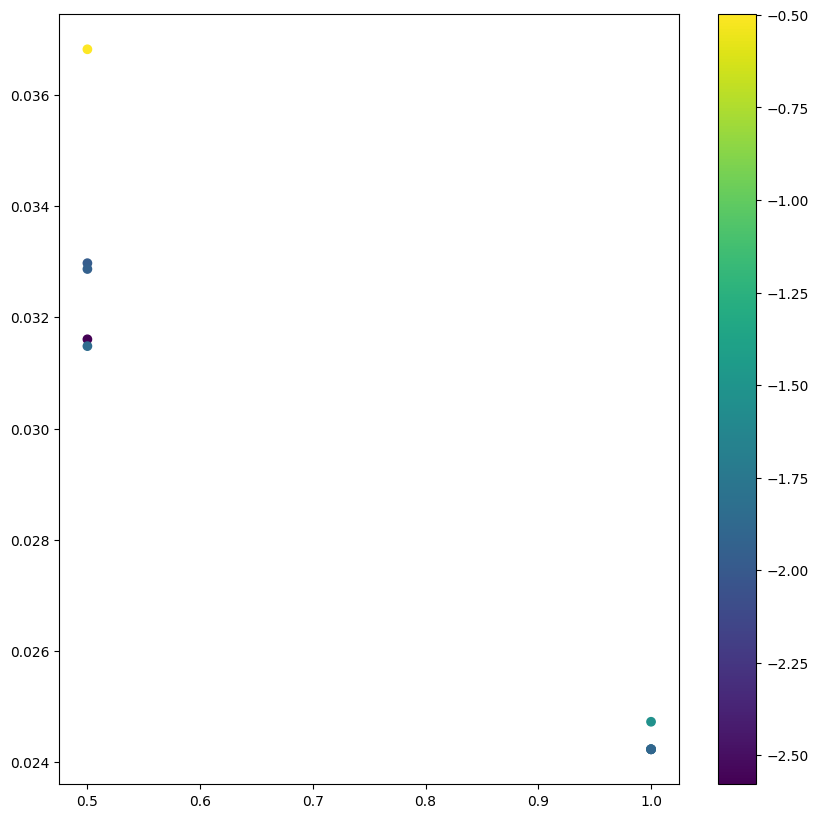

In [130]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,10))
cmap = ax.scatter(x=X_unsqueezed[:number_of_element,:,-1].squeeze().detach().numpy(),y = acquisition_values.detach().numpy(),c = S_exp.fitness_acquired[:number_of_element]) 
fig.colorbar(cmap)